## Rosebrock optimization with box constraints

This notebook explores the avenue of solving a nonlinear functional with box constraints

$$
\mathbf{x} = f(x) \quad s.t. \quad \mathbf{x}
        \in I_{Box}
$$

where f is the Rosebrock function

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from time import sleep
import numpy as np
import scipy
import matplotlib
import warnings
import torch
import torch.nn as nn
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from matplotlib import gridspec 
from pyproximal import Nonlinear, Box
from pyproximal.optimization.primal import ProximalGradient, ADMM

In [2]:
def rosenbrock(x, y, a=1, b=10):
    f = (a - x)**2 + b*(y - x**2)**2
    return f

def rosenbrock_grad(x, y, a=1, b=10):
    dfx = -2*(a - x) - 2*b*(y - x**2) * 2 * x
    dfy = 2*b*(y - x**2)
    return dfx, dfy

In [3]:
def contour_rosenbrock(x, y, reg=None, tau=None, plotmin=False):
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Make the function
    x, y = np.meshgrid(x, y)
    z = rosenbrock(x, y)
    
    if reg is not None:
        z += 1. / (2*tau) * ((reg[0] - x)**2 + (reg[1] - y)**2)

    # Plot the surface.
    surf = ax.contour(x, y, z, 200, cmap='gist_heat_r', vmin=-20, vmax=200,
                      linewidth=0, antialiased=False)
    if plotmin:
        ax.scatter(x.ravel()[np.argmin(z.ravel())], y.ravel()[np.argmin(z.ravel())], c='r', s=100)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    return fig, ax

In [4]:
class Rosebrock(Nonlinear):
    def setup(self, a=1, b=10, alpha=1.):
        self.a, self.b = a, b
        self.alpha = alpha
    def fun(self, x):
        return np.array(rosenbrock(x[0], x[1], a=self.a, b=self.b))
    def grad(self, x):
        return np.array(rosenbrock_grad(x[0], x[1], a=self.a, b=self.b))
    """
    def optimize(self):
        self.solhist = []
        sol = self.x0.copy()
        for iiter in range(self.niter):
            x1, x2 = sol
            dfx1, dfx2 = self._gradprox(sol, self.tau)
            x1 -= self.alpha * dfx1
            x2 -= self.alpha * dfx2
            sol = np.array([x1, x2])
            self.solhist.append(sol)
        self.solhist = np.array(self.solhist)
        return sol
    """
    def optimize(self):
        def callback(x):
            self.solhist.append(x)
        
        self.solhist = []
        self.solhist.append(self.x0)
        sol = scipy.optimize.minimize(lambda x: self._funprox(x, self.tau),
                                      x0=self.x0, jac=lambda x: self._gradprox(x, self.tau), 
                                      method='L-BFGS-B', callback=callback, options=dict(maxiter=15))
        sol = sol.x
        
        self.solhist = np.array(self.solhist)
        return sol

### Unconstrained optimization

We start with simple gradient descent

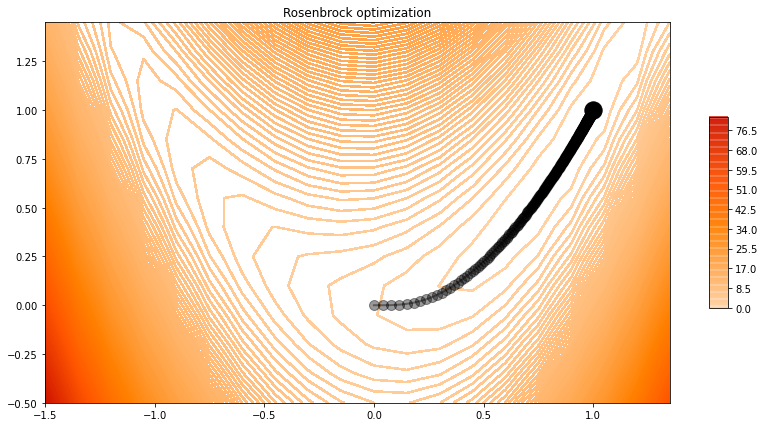

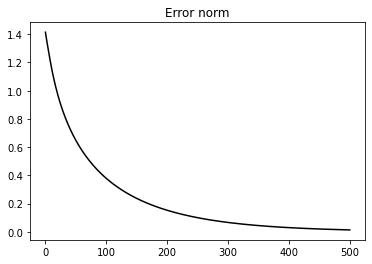

In [5]:
# Constant-step size optimization
niters = 500
alpha = 0.02

steps = [(0, 0), ]
for iiter in range(niters):
    x, y = steps[-1]
    dfx, dfy = rosenbrock_grad(x, y)
    x -= alpha * dfx
    y -= alpha * dfy
    steps.append((x, y))

x = np.arange(-1.5, 1.5, 0.15)
y = np.arange(-0.5, 1.5, 0.15)
nx, ny = len(x), len(y)
_, ax = contour_rosenbrock(x, y)
steps = np.array(steps)
ax.plot(steps[:, 0], steps[:, 1], '.-k', lw=2, ms=20, alpha=0.4)
ax.scatter(1, 1, c='k', s=300)
ax.set_title('Rosenbrock optimization')

plt.figure()
plt.plot(np.linalg.norm(steps - [1,1], axis=1), 'k')
plt.title('Error norm');

### Constrained optimization

Let's now use proximal gradient adding a box constraint. The inner step for f will still call a nonlinear gradient descent but now on the proximal cost function.

Text(0.5, 1.0, 'Rosenbrock optimization (proximal)')

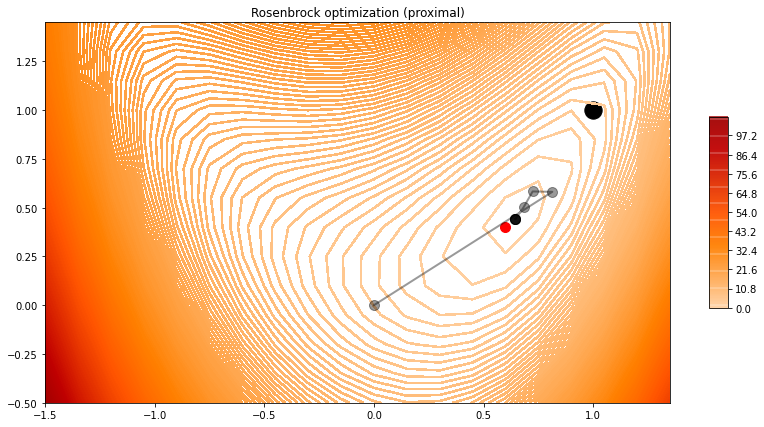

In [6]:
# First solve just the proximal
fnl = Rosebrock(x0=np.zeros(2), niter=200, warm=True)
fnl.setup(1, 10, alpha=0.02)

fnl.y = 0.5 * np.ones(2)
fnl.tau = 0.1
fnl.optimize()

_, ax = contour_rosenbrock(x, y, fnl.y, fnl.tau,plotmin=True)
steps = np.array(steps)
ax.plot(fnl.solhist[:, 0], fnl.solhist[:, 1], '.-k', lw=2, ms=20, alpha=0.4)
ax.scatter(1, 1, c='k', s=300)
ax.set_title('Rosenbrock optimization (proximal)')

In [7]:
xbound = np.arange(-1.5, 1.5, 0.01)
ybound = np.arange(-0.5, 1.5, 0.01)

m1, m2 = np.meshgrid(xbound, ybound, indexing='ij')
mgrid = np.vstack((m1.ravel(), m2.ravel()))

lower = 0.6
upper = 1.2
indic = (mgrid > lower) & (mgrid < upper)
indic = indic[0].reshape(xbound.size, ybound.size) & indic[1].reshape(xbound.size, ybound.size)

In [8]:
fnl = Rosebrock(niter=20, x0=np.zeros(2), warm=True)
fnl.setup(1, 10, alpha=0.02)
ind = Box(lower, upper)

def callback(x):
    mhist.append(x)

m0 = np.array([0, 0])

mhist = [m0,]
minv_slow = ProximalGradient(fnl, ind,
                             tau=0.001,
                             x0=m0, epsg=1.,
                             niter=5000,
                             callback=callback)
mhist_slow = np.array(mhist)

Text(0.5, 1.0, 'Rosenbrock optimization')

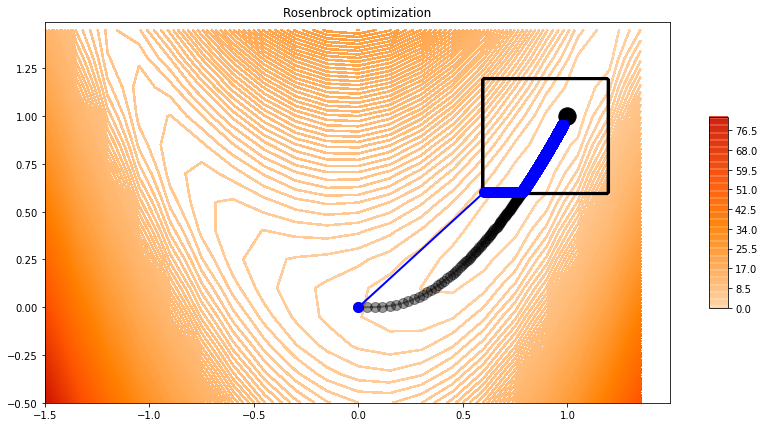

In [9]:
_, ax = contour_rosenbrock(x, y)
steps = np.array(steps)
ax.plot(steps[:, 0], steps[:, 1], '.-k', lw=2, ms=20, alpha=0.4)
ax.contour(m1, m2, indic, colors='k')
ax.scatter(1, 1, c='k', s=300)
ax.plot(mhist_slow[:, 0], mhist_slow[:, 1], '.-b', ms=20, lw=2)
ax.set_title('Rosenbrock optimization')

In [10]:
fnl = Rosebrock(niter=20, x0=np.zeros(2), warm=True)
fnl.setup(1, 10, alpha=0.02)
ind = Box(lower, upper)

def callback(x):
    mhist.append(x)

m0 = np.array([0, 0])

mhist = [m0,]
minv_slow = ADMM(fnl, ind,
                 tau=1.,
                 x0=m0,
                 niter=30, show=True,
                 callback=callback)
mhist_slow = np.array(mhist)

ADMM
---------------------------------------------------------
Proximal operator (f): <class '__main__.Rosebrock'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
tau = 1.000000e+00	niter = 30

   Itn       x[0]          f           g       J = f + g
     1   5.56967e-01   1.985e-01   0.000e+00   1.985e-01
     2   9.17533e-01   6.890e-03   1.000e+00   1.007e+00
     3   8.86812e-01   1.318e-02   1.000e+00   1.013e+00
     4   9.05365e-01   9.178e-03   1.000e+00   1.009e+00
     5   9.34197e-01   4.406e-03   1.000e+00   1.004e+00
     6   9.53886e-01   2.163e-03   1.000e+00   1.002e+00
     7   9.67451e-01   1.077e-03   1.000e+00   1.001e+00
     8   9.76913e-01   5.418e-04   1.000e+00   1.001e+00
     9   9.83569e-01   2.744e-04   1.000e+00   1.000e+00
    10   9.88278e-01   1.396e-04   1.000e+00   1.000e+00
    13   9.95709e-01   1.871e-05   1.000e+00   1.000e+00
    16   9.98421e-01   2.534e-06   1.000e+00   1.000e+00
    19   9.99414e-01   3.483e-07   1.000e+00   1.000

Text(0.5, 1.0, 'Rosenbrock optimization')

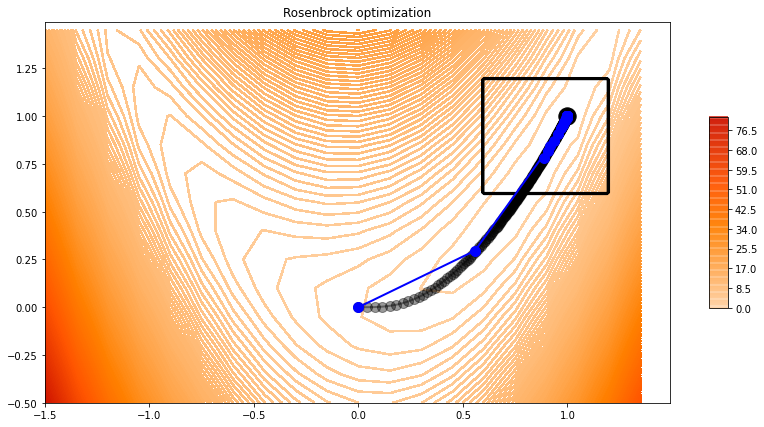

In [11]:
_, ax = contour_rosenbrock(x, y)
steps = np.array(steps)
ax.plot(steps[:, 0], steps[:, 1], '.-k', lw=2, ms=20, alpha=0.4)
ax.contour(m1, m2, indic, colors='k')
ax.scatter(1, 1, c='k', s=300)
ax.plot(mhist_slow[:, 0], mhist_slow[:, 1], '.-b', ms=20, lw=2)
ax.set_title('Rosenbrock optimization')

## Using pytorch

In [12]:
class Rosenbrock_torch(nn.Module):
    def __init__(self, a=1, b=10):
        super().__init__()
        self.a, self.b = a, b
    
    def forward(self, x):
        x1 = x[0]
        x2 = x[1]
        f = (self.a - x1)**2 + self.b *(x2 - x1**2)**2
        return f
    
    def optimize(self, x):
        x.requires_grad = True
        optimizer = torch.optim.Adam([x], lr=1e-2, betas=(0.5, 0.9))
        steps = []
        funcs = []
        grads = []
        for i in range(400):
            optimizer.zero_grad()
            f = self.forward(x)
            f.backward()
            optimizer.step()
            steps.append(x.detach().numpy().copy().squeeze())
            funcs.append(f.detach().numpy().copy())
            grads.append(x.grad.norm().detach().numpy().copy())
        return steps, funcs, grads

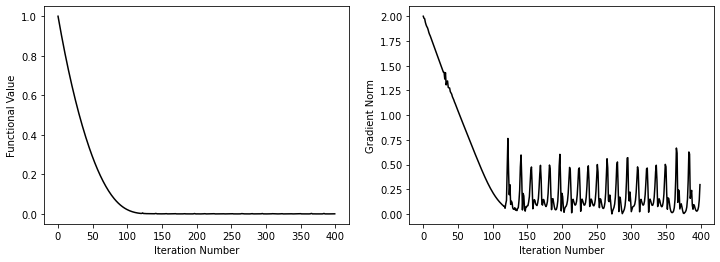

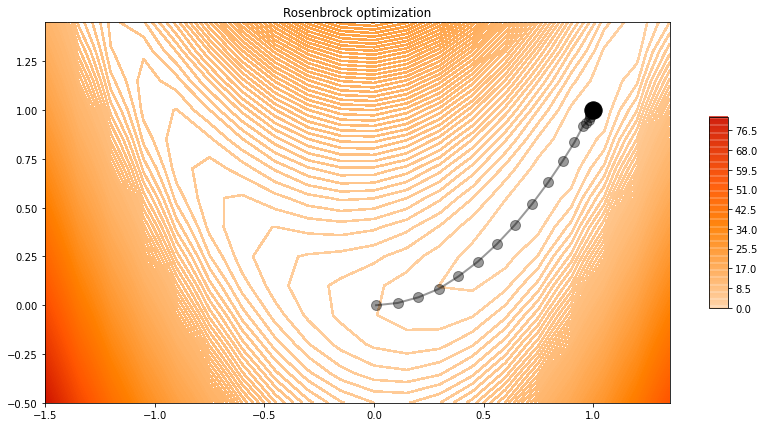

In [13]:
rosenbrock_torch = Rosenbrock_torch()    
steps, funcs, grads = rosenbrock_torch.optimize(torch.zeros(2))

fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].plot(funcs, 'k')
ax[0].set_xlabel("Iteration Number")
ax[0].set_ylabel("Functional Value")
ax[1].plot(grads, 'k')
ax[1].set_xlabel("Iteration Number")
ax[1].set_ylabel("Gradient Norm");

x = np.arange(-1.5, 1.5, 0.15)
y = np.arange(-0.5, 1.5, 0.15)
_, ax = contour_rosenbrock(x, y)

# Add optimization trajectory
steps = np.array(steps)
ax.plot(steps[::10, 0], steps[::10, 1], '.-k', lw=2, ms=20, alpha=0.4)
ax.scatter(1, 1, c='k', s=300)
ax.set_title('Rosenbrock optimization');

In [14]:
class Rosenbrock_torch(nn.Module):
    def __init__(self, a=1, b=10):
        super().__init__()
        self.a, self.b = a, b

    def forward(self, x):
        x1 = x[0]
        x2 = x[1]
        f = (self.a - x1)**2 + self.b *(x2 - x1**2)**2
        return f
    

class Rosebrock(Nonlinear):
    def setup(self, a=1, b=10, alpha=1., return_torch=True):
        self.a, self.b = a, b
        self.alpha = alpha
        self.rose_torch = Rosenbrock_torch()
        self.return_torch = return_torch
    def fun(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.from_numpy(x)
        y = self.rose_torch.forward(x)
        if not self.return_torch:
            y = y.detach().numpy()
        return y
    
    def grad(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.from_numpy(x)
        x.requires_grad = True
        y = self.rose_torch.forward(x)
        y.backward()
        y = x.grad
        if not self.return_torch:
            y = y.detach().numpy()
        return y
    
    def optimize(self):
        self.y = torch.from_numpy(self.y)
        x = torch.from_numpy(self.x0)
        x.requires_grad = True
        #optimizer = torch.optim.Adam([x], lr=self.alpha, betas=(0.5, 0.9))
        optimizer = torch.optim.SGD([x], lr=self.alpha)
        self.solhist = []
        self.funcs = []
        self.grads = []
        for i in range(self.niter):
            optimizer.zero_grad()
            f = self._funprox(x, self.tau)
            f.backward()
            optimizer.step()
            self.solhist.append(x.detach().numpy().copy().squeeze())
            self.funcs.append(f.detach().numpy().copy())
            self.grads.append(x.grad.norm().detach().numpy().copy())
        self.solhist = np.array(self.solhist)
        return self.solhist[-1]

[0.64418851 0.44331922]


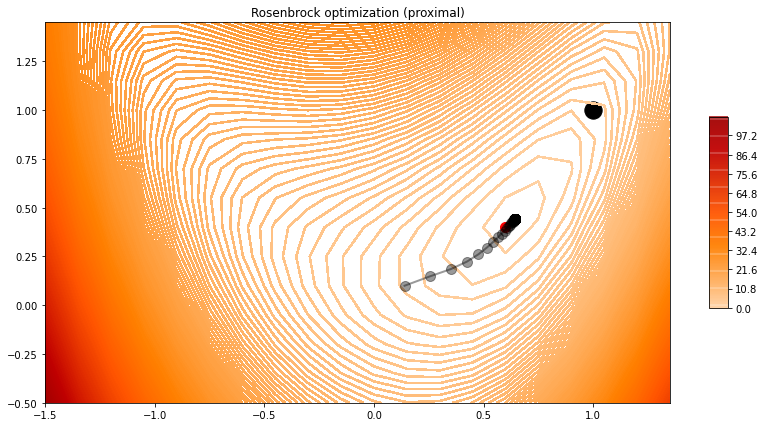

In [15]:
# First solve just the proximal
fnl = Rosebrock(x0=np.zeros(2), niter=200, warm=True)
fnl.setup(1, 10, alpha=0.02, return_torch=True)

fnl.y = 0.5 * np.ones(2)
fnl.tau = 0.1
sol = fnl.optimize()
print(sol)

_, ax = contour_rosenbrock(x, y, fnl.y.numpy(), fnl.tau,plotmin=True)
steps = np.array(steps)
ax.plot(fnl.solhist[:, 0], fnl.solhist[:, 1], '.-k', lw=2, ms=20, alpha=0.4)
ax.scatter(1, 1, c='k', s=300)
ax.set_title('Rosenbrock optimization (proximal)');

In [16]:
fnl = Rosebrock(niter=20, x0=np.zeros(2), warm=True)
fnl.setup(1, 10, alpha=0.02, return_torch=False)
ind = Box(lower, upper)

def callback(x):
    mhist.append(x)

m0 = np.array([0., 0.])

mhist = [m0,]
minv_slow = ProximalGradient(fnl, ind,
                             tau=0.001,
                             x0=m0, epsg=1.,
                             niter=5000,
                             callback=callback)
mhist_slow = np.array(mhist)

Text(0.5, 1.0, 'Rosenbrock optimization')

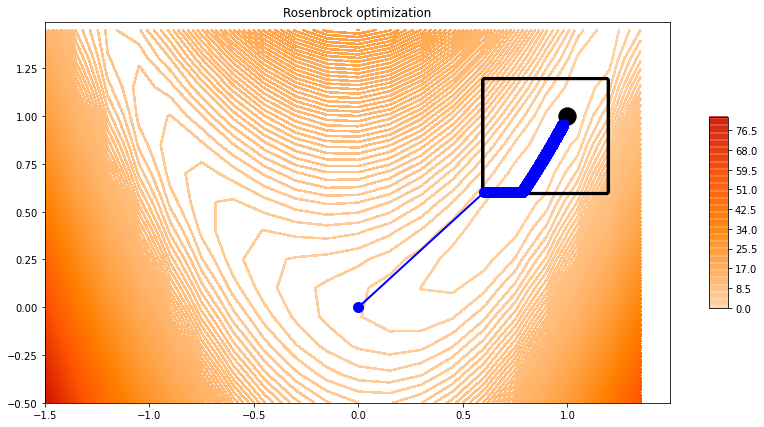

In [17]:
_, ax = contour_rosenbrock(x, y)
ax.contour(m1, m2, indic, colors='k')
ax.scatter(1, 1, c='k', s=300)
ax.plot(mhist_slow[:, 0], mhist_slow[:, 1], '.-b', ms=20, lw=2)
ax.set_title('Rosenbrock optimization')

In [18]:
fnl = Rosebrock(niter=20, x0=np.zeros(2), warm=True)
fnl.setup(1, 10, alpha=0.02, return_torch=True)
ind = Box(lower, upper)

def callback(x):
    mhist.append(x)

m0 = np.array([0., 0.])

mhist = [m0,]
minv_slow = ADMM(fnl, ind,
                 tau=1.,
                 x0=m0,
                 niter=30, show=True,
                 callback=callback)
mhist_slow = np.array(mhist)

ADMM
---------------------------------------------------------
Proximal operator (f): <class '__main__.Rosebrock'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
tau = 1.000000e+00	niter = 30

   Itn       x[0]          f           g       J = f + g
     1   4.05651e-01   3.591e-01   0.000e+00   3.591e-01
     2   7.23299e-01   7.695e-02   0.000e+00   7.695e-02
     3   8.48264e-01   2.309e-02   1.000e+00   1.023e+00
     4   9.05255e-01   8.986e-03   1.000e+00   1.009e+00
     5   9.17660e-01   6.910e-03   1.000e+00   1.007e+00
     6   9.04521e-01   9.516e-03   1.000e+00   1.010e+00
     7   9.17031e-01   7.010e-03   1.000e+00   1.007e+00
     8   9.28365e-01   5.222e-03   1.000e+00   1.005e+00
     9   9.38010e-01   3.910e-03   1.000e+00   1.004e+00
    10   9.46245e-01   2.939e-03   1.000e+00   1.003e+00
    13   9.64619e-01   1.273e-03   1.000e+00   1.001e+00
    16   9.76484e-01   5.622e-04   1.000e+00   1.001e+00
    19   9.84273e-01   2.514e-04   1.000e+00   1.000

Text(0.5, 1.0, 'Rosenbrock optimization')

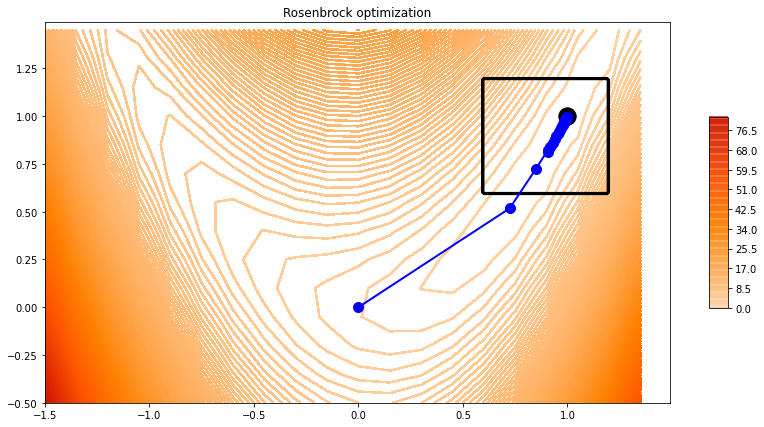

In [19]:
_, ax = contour_rosenbrock(x, y)
ax.contour(m1, m2, indic, colors='k')
ax.scatter(1, 1, c='k', s=300)
ax.plot(mhist_slow[:, 0], mhist_slow[:, 1], '.-b', ms=20, lw=2)
ax.set_title('Rosenbrock optimization')